# TP 1 NLP :  LE PRETRAITEMENT EN NLP 

**Nom: Senhadji M Said**

Dans ce notebook jupyter, vous trouvez la solution du TP + l'explication de mon implémentation

 (Il contient donc la solution + le rapport)


In [ ]:
import nltk
import spacy
from wordcloud import WordCloud
from pywaffle import Waffle
import matplotlib.pyplot as plt
import re
from textblob import TextBlob, Word

 Chargement du modèle dans SpaCy
 

In [3]:
nlp = spacy.load("en_core_web_lg")

In [8]:
doc = nlp("Natural Language Processing is amazing!")
for token in doc:
    print(f"{token.text} → {token.lemma_} ({token.pos_})")

Natural → Natural (PROPN)
Language → Language (PROPN)
Processing → Processing (PROPN)
is → be (AUX)
amazing → amazing (ADJ)
! → ! (PUNCT)


# A. Préparation de données


In [9]:
import pandas as pd
df = pd.read_csv('spooky.csv')

In [10]:
df.columns

Index(['id', 'text', 'author'], dtype='object')

In [11]:
df.head(n=10)

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL
5,id22965,"A youth passed in solitude, my best years spen...",MWS
6,id09674,"The astronomer, perhaps, at this point, took r...",EAP
7,id13515,The surcingle hung in ribands from my body.,EAP
8,id19322,I knew that you could not say to yourself 'ste...,EAP
9,id00912,I confess that neither the structure of langua...,MWS


# B. Nettoyage d’un texte

### Gérer les caractères répétitifs (par exemple « cooooool » → « cool »)

In [12]:
def remove_repititive_chars(word,rx=re.compile(r'([^\W\d_])\1{2,}')):
    return re.sub(r'[^\W\d_]+', lambda x: Word(rx.sub(r'\1\1', x.group())).correct() if rx.search(x.group()) else x.group(), word)

In [16]:
remove_repititive_chars("cooool , haaaapy, niceee")

'cool , happy, nice'

#### 📌 Code Breakdown of `remove_repititive_chars` function

1️⃣ Understanding the Regular Expression
 
```python
   rx = re.compile(r'([^\W\d_])\1{2,}')
```
This regex detects characters that repeat 3 times or more and prepares them for correction: 
 - `[^\W\d_]` → Matches any letter (excludes non-word characters, digits, and underscores). 
 - `\1{2,}` → Captures at least 2 more occurrences of the same letter (total = 3 or more).

Example Matches:

   | input | Matched part |
   | -------| ---------------- |
   | `"cooooool"`  | `ooooo`         |
   | `"heeeellooo"`   | `"eee", "ll", "ooo"`        |

2️⃣ `re.sub()` for Text Processing
```python
re.sub(
    r'[^\W\d_]+',  
    lambda x: Word(rx.sub(r'\1\1', x.group())).correct() if rx.search(x.group()) else x.group(),  
    word
)
```
- Pattern `r'[^\W\d_]+'` Matches whole words (excludes special characters and numbers).
- Lambda Function : 
  - If a word contains repetitive letters `rx.search(x.group())`
    1. Replaces excessive repetitions `rx.sub(r'\1\1', x.group())`
    2. Applies spelling correction using `Word(...).correct()`
  - If there are no repetitions, the word remains unchanged.

Example Transformations:

   | input | Intermediate (2-letter max) | Final Output (Spell Correction) |
   | -------| ---------------- | ------ |
   | `"cooooool"`  | `cool`         | `cool` |
   | `"heeeellooo"`   | `heelloo`        | `hello` |
   | `sooooooo`   | `soo` | `so` |

    

In [18]:
df["text"] = df["text"].apply(remove_repititive_chars)

### 2. Manipuler des homoglyphes (par exemple « $tupide » → « stupide ») 

In [25]:
print(Word("$tupid").correct())
print(Word("th3").correct())
print(Word("4lg3bra").correct())

stupid
the
algebra


The code `print(Word("$tupid").correct())` uses TextBlob to correct the spelling of the word by replacing "$tupid" with a correct word (probably "stupid"). However, TextBlob does not handle homoglyphs directly, it only recognizes common misspellings.

In [26]:
from unidecode import unidecode

def normalize_unicode_chars(text):
    text = unidecode(text)
    return text

This function normalizes Unicode characters by converting special characters into their closest ASCII equivalent. It helps in handling homoglyphs (e.g., "ℌ" → "H") and removing accents (e.g., "é" → "e").

In [27]:
print(normalize_unicode_chars("ℌello Wörld! Ça va?"))

Hello World! Ca va?


In [28]:
df["text"] = df["text"].apply(normalize_unicode_chars)

### 3.  Transformer les entrées spéciales telles que les URL, les adresses e-mail et les balises HTML à une forme canonique.  

#### 3.1 Canonicalize URLs

In [29]:
from url_normalize import url_normalize

def canonical_url(u):
    u = url_normalize(u)
    u = u.split('?')[0]

    if u.startswith("http://"):
        u = u[7:]
    if u.startswith("https://"):
        u = u[8:]
    if u.startswith("www."):
        u = u[4:]
    if u.endswith("/"):
        u = u[:-1]
    return u

What this does:

- Removes "http://" and "https://" to keep a clean domain name.
- Removes "www." to standardize the URL.
- Removes query parameters and trailing slashes.

In [30]:
print(canonical_url("https://www.example.com/index.html?utm_source=google"))

example.com/index.html


####  3.2 Normalize Emails

In [37]:
import nest_asyncio
import email_normalize

# Apply workaround for asyncio issue in Jupyter Notebook
nest_asyncio.apply()

def normalize_email(email_address: str):
    result = email_normalize.normalize(email_address)
    return result.normalized_address

What this does:

- Converts emails to a standardized form (e.g., lowercase, removing aliases).
- Helps in removing case-sensitive variations of the same email.

In [40]:
print(normalize_email("ms.senhadji+2AISD@Gmail.com"))

mssenhadji@gmail.com


#### 3.3 Remove HTML Tags

In [41]:
from bs4 import BeautifulSoup
import re

def remove_html_tags(text):
    return re.sub(" +", " ", BeautifulSoup(text, 'html.parser').get_text().replace("\n", " ")).strip()


What this does:

- Extracts only text from HTML content.
- Removes line breaks (\n) and extra spaces.

In [44]:
remove_html_tags("""
<!DOCTYPE html>
<html>
<head>
<title>Page Title</title>
</head>
<body>
<h1>This is a Heading</h1>
<p>This is a paragraph.</p>
</body>
</html>
""")


'Page Title This is a Heading This is a paragraph.'

#### 3.4 Apply All Normalizations to Text

In [45]:
url_regex = r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*"
email_regex = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'

def handle_special_entries(text):
    text = re.sub(url_regex, lambda x: canonical_url(x.group()), text)  
    text = re.sub(email_regex, lambda x: normalize_email(x.group()), text)  
    text = remove_html_tags(text)  
    return text


In [46]:
text = "Check this website: https://www.example.com/home?ref=ads. Contact me at ms.senhadji@ei-sba.DZ <p>Important text</p>"
print(handle_special_entries(text))


Check this website: example.com/home Contact me at ms.senhadji@ei-sba.dz Important text


In [47]:
df["text"] = df["text"].apply(handle_special_entries)

### 4. Mettre tous les caractères en minuscule.

In [48]:
df["text"] = df["text"].apply(str.lower)

### 5. Supprimer  la ponctuation

In [53]:
import string

spetial_chars = string.punctuation
escaped_chars = [re.escape(c) for c in spetial_chars]
spetial_chars_regex = re.compile(f"({'|'.join(escaped_chars)})")

- `string.punctuation` is a built-in constant in Python that contains all common punctuation characters.
- `re.escape(c)` escapes any special character in spetial_chars so that it can be safely used in a regex pattern.
- `'|'.join(escaped_chars)` joins them with |, forming a regex pattern that matches any punctuation.
  **Final Regex Pattern:**
  ```text
  (!|\$|%|&|'|\(|\)|\*|\+|,|-|\.|/|:|;|<|=|>|\?|@|\[|\\|\]|\^|_|`|{|\||}|~)

  ```

In [54]:
def remove_punctuation(text):
  return re.sub(spetial_chars_regex," ",text)

What this does:

- Removes punctuation except for spaces.
- Ensures that words are separated properly.

In [55]:
remove_punctuation("Hello,World !")

'Hello World  '

In [56]:
df["text"] = df["text"].apply(remove_punctuation)

### 6.  Supprimer les mots-vide.

In [58]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

eng_stopwords = set(stopwords.words("english"))

def remove_stopwords(text):
    tokens = word_tokenize(text)  
    tokens = [token for token in tokens if token not in eng_stopwords] 
    return ' '.join(tokens)  


How It Works?
1. Load Stopwords:

  - `stopwords.words("english")` loads a list of common English stopwords (e.g., "the", "and", "is", etc.).
  - `set(stopwords.words("english"))` makes the lookup faster.
2. Tokenize Text:

  - `word_tokenize(text)` splits the text into individual words.
3. Filter Stopwords:

  - The list comprehension keeps only words not in `eng_stopwords`.
4. Reconstruct Cleaned Text:

  - `' '.join(tokens)` merges words back into a sentence.

In [59]:
df["text"] = df["text"].apply(remove_stopwords)

### 7.  Détecter les langues présentes dans le dataset et les traduire vers la langue la plus fréquente. 

In [64]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException
from collections import Counter
from deep_translator import GoogleTranslator

DetectorFactory.seed = 0
def safe_detect(text):
    try:
        text = text.strip()
        if len(text) < 5:  # Skip very short texts
            return "unknown"
        return detect(text)
    except LangDetectException:
        return "unknown"

df["language"] = df["text"].apply(safe_detect)

lang_counts = Counter(df["language"])
lang_counts.pop("unknown", None)  
most_frequent_lang = lang_counts.most_common(1)[0][0] if lang_counts else "en"

In [65]:
print(f"Most frequent language: {most_frequent_lang}")

Most frequent language: en


In [66]:
def translate_to_most_frequent(text, lang):
    if lang != most_frequent_lang and lang != "unknown":
        return GoogleTranslator(source=lang, target=most_frequent_lang).translate(text)
    return text

### 9. Supprimer les répétitions de mots (par exemple : "un un un...") et les espaces inutiles.

In [68]:
def remove_repeated_words(text):
    return re.sub(r'\b(\w+)( \1\b)+', r'\1', text)  

def clean_extra_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()  

df["text"] = df["text"].apply(remove_repeated_words)
df["text"] = df["text"].apply(clean_extra_spaces)

# C. Segmentation

### 1.  Segmenter chaque phrase sur les espaces / la ponctuation

In [69]:
space_based_vocab = []

In [71]:
_ = df["text"].apply(lambda x : space_based_vocab.extend(word_tokenize(x)))
space_based_vocab = set(space_based_vocab)
len(space_based_vocab)

24911

**Code Breakdown:**
1. `df["text"].apply(lambda x: space_based_vocab.extend(word_tokenize(x)))`:
   - For each row in the DataFrame (`df["text"]`), it applies the function to tokenize the sentence into words (using `word_tokenize`).
2. `space_based_vocab = set(space_based_vocab)`:
   - Converts `space_based_vocab` to a set to remove any duplicate words, keeping only unique tokens.

**Explanation**:
- ``word_tokenize`` handles both spaces and punctuation, so it automatically splits the text into meaningful tokens (words, punctuation).

### 2.  Segmenter chaque phrase avec un algorithme de segmentation basé sur des règles 

- Rule 1 : ``Hello World -> [Hello, World]``
- Rule 2 : ``can't -> [can,not]``
- Rule 3 : ``won't -> [will,not]``
- Rule 4 : ``gimme -> [give, me]``
- Rule 5 : ``don't -> [do, not]``

In [72]:
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.attrs import ORTH, NORM

def make_tokenizer():

    rules = {
        "can't":[{ORTH: "ca",NORM:"can"}, {ORTH: "n't", NORM:"not"}],
        "don't":[{ORTH: "do"}, {ORTH: "n't", NORM:"not"}],
        "won't":[{ORTH: "wo",NORM:"will"}, {ORTH: "n't", NORM:"not"}],
        "gimme":[{ORTH: "gim",NORM:"give"}, {ORTH: "me"}],
    }


    nlp = English()
    tokenizer = Tokenizer(nlp.vocab,rules=rules)

    return tokenizer

1. **Custom Tokenizer with Rules**:
   - We define a tokenizer with special rules to split contractions (e.g., ``"can't" → ["can", "not"]``) and informal words (e.g., ``"gimme" → ["give", "me"]``).
   - Each rule is a dictionary mapping words to a list of tokens with ``ORTH`` (original form) and ``NORM`` (normalized form).
2. **Creating a SpaCy Tokenizer**:
   - We initialize a blank English NLP model (``nlp = English()``).
   - The ``Tokenizer(nlp.vocab, rules=rules)`` tries to apply the custom rules.


In [73]:
tokenizer = make_tokenizer()
text = "don't can't won't gimme hello world"
print([t.norm_ for t in tokenizer(text)])

['do', 'not', 'can', 'not', 'will', 'not', 'give', 'me', 'hello', 'world']


In [75]:
rule_based_vocab = []
_ = df["text"].apply(lambda x : rule_based_vocab.extend([t.norm_ for t in tokenizer(x)]))
rule_based_vocab = set(rule_based_vocab)
len(rule_based_vocab)

24911

### 3.  Segmenter chaque phrase  avec un algorithme de segmentation en sous mots (Subword Tokenization) 

In [76]:
from word_piece_tokenizer import WordPieceTokenizer

tokenizer = WordPieceTokenizer()

In [77]:
def wordpiece(text):
    ids = tokenizer.tokenize(text)
    return tokenizer.convert_ids_to_tokens(ids)

1. **Initializing the WordPiece Tokenizer**:
   - ``tokenizer = WordPieceTokenizer()`` creates a tokenizer based on the WordPiece algorithm, commonly used in models like BERT.
   - WordPiece splits words into smaller subwords to handle unknown words and improve model efficiency (e.g., ``"playing" → ["play", "##ing"]``).
2. **Defining the Tokenization Function**:
   - ``tokenizer.tokenize(text)`` converts the input text into token IDs.
   - ``tokenizer.convert_ids_to_tokens(ids)`` maps these IDs back to readable token strings.

In [80]:
subword_vocab = []
_ = df["text"].apply(lambda x : subword_vocab.extend(wordpiece(x)))
subword_vocab = set(subword_vocab)
len(subword_vocab)

15824

## D. Reconnaissance d'entité nommée 

### 1. Pour chaque phrase représentait les entités nommées (avec NLTK ou SpaCy), 2. Pour chaque phrase, réaliser l'analyse des POS tags (part-of-speech). 

In [81]:
nlp = spacy.load("en_core_web_lg")

In [86]:
sample_text = df["text"].iloc[31]
doc = nlp(sample_text)

In [87]:
print(f'The text: {sample_text}')
print(f'\nNamed Entities:\n')

for i, ent in enumerate(doc.ents):
    print(f"NER {i} = (text={ent.text}, start_char={ent.start_char}, end_char={ent.end_char}, label={ent.label_})")

The text: rich young guardian appointed would act one great society must keep secret really cut ever

Named Entities:

NER 0 = (text=one, start_char=40, end_char=43, label=CARDINAL)


1. **Processing a Text Sample**:
   - ``doc = nlp(df["text"].iloc[50])`` applies the NLP pipeline to the 50th text from the dataset.
2. **Extracting Named Entities**:
   - ``doc.ents`` contains all named entities recognized by SpaCy.
   - Each entity (``ent``) has attributes
       - ent.text: Extracted named entity (e.g., ``"Google"``).
       - ``ent.start_char`` & ``ent.end_char``: Start & end positions of the entity in the text.
       - ``ent.label_``: The entity type (e.g., ``"ORG"`` for organizations, "PERSON" for people).

## E. Réduction des formes 
### 1. Avec NLTK utiliser la lemmatisation et la racinisation. 

In [88]:
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer(language="english")

In [89]:
def stem(text):
  tokens = word_tokenize(text)
  token = [stemmer.stem(token) for token in tokens]
  return ' '.join(token)

In [93]:
stemmer.stem("generalization")

'general'

In [94]:
df["stemmed_text"] = df["text"].apply(stem)


📌 **Stemming**
- Stemming **removes word endings** to get the root form of a word.
- Example:
  - ``"running"`` → ``"run"``
  - ``"cats"`` → ``"cat"``
  - ``"better"`` → ``"better"`` (incorrect because stemming doesn’t handle meaning)
- Algorithm Used: ``SnowballStemmer`` 

In [98]:
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...


In [96]:
def lemmatize(text):
  tokens = word_tokenize(text)
  token = [lemmatizer.lemmatize(token) for token in tokens]
  return ' '.join(token)

In [99]:
df["lemmatized_text"] = df["text"].apply(lemmatize)

📌 **Lemmatization**
- Lemmatization **reduces words** to their base form (lemma) using a dictionary.
- Example:
  - ``"running"`` → ``"run"``
  - ``"cats"`` → ``"cat"``
  - ``"better"`` → ``"good"`` (correct because it considers meaning)
- Algorithm Used: ``WordNetLemmatizer`` (uses POS tagging for better accuracy)

📌  **Why Use POS Tagging for Lemmatization?**
- ``"running"`` can be a verb (run) or a noun (running event).
- With POS:
  - Verb: ``"running"`` → ``"run"``
  - Noun: ``"running"`` → ``"running"``
- Better accuracy in lemmatization by mapping POS tags to WordNet format.

## F. Analyse des fréquences 
### 1. Compter le nombre de phrases, pour chaque auteur, où apparaît le mot Great. 

In [100]:
grouped_df = df[["text","author"]].groupby(by="author").agg(' '.join)

- Groups all texts (``"text"``) by their corresponding author (``"author"``).
- Joins all texts from the same author into a single string.

In [102]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer().fit(grouped_df["text"])
counts = cv.transform(grouped_df["text"])

- ``CountVectorizer()`` converts text into a bag-of-words representation.
- It tokenizes the text and counts word occurrences.
- ``.fit()`` learns the vocabulary.
- ``.transform()`` converts the text into a word frequency matrix.

In [103]:
counts_df = pd.DataFrame(data=counts.toarray(),index=grouped_df.index,columns=cv.get_feature_names_out())

- Converts the sparse matrix (``counts``) into a Pandas DataFrame.
- Rows correspond to authors, and columns correspond to words.

In [104]:
counts_df["great"]

author
EAP    222
HPL    183
MWS     90
Name: great, dtype: int64

### 2. Utiliser pywaffle pour obtenir un graphique qui résume de manière synthétique le nombre d’occurrences du mot “ great ” par auteur. 

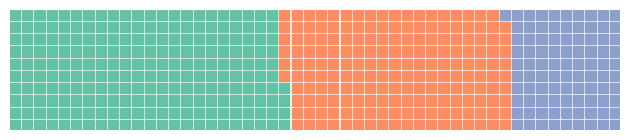

In [105]:
_ = plt.figure(
    FigureClass=Waffle,
    rows=10,
    columns=50,
    values=counts_df['great'],
)

### 3. Refaire l’analyse avec le mot “impossible ”. 

In [106]:
counts_df["impossible"]

author
EAP    64
HPL    16
MWS    19
Name: impossible, dtype: int64

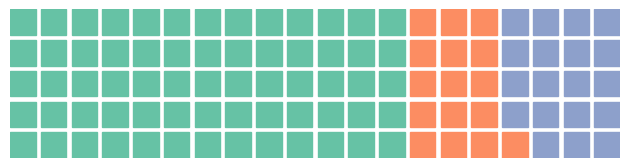

In [107]:
_ = plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=20,
    values=counts_df['impossible'],
)

### 4. En utilisant la fonction wordCloud, faire trois nuages de mots pour représenter les mots les plus utilisés par chaque auteur. 

In [108]:
def show_wordclouds(grouped_df, author):
    wc1 = WordCloud().generate(grouped_df["text"].loc[author])
    plt.imshow(wc1)

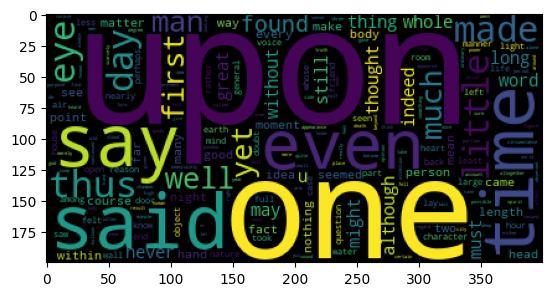

In [109]:
show_wordclouds(grouped_df, "EAP")

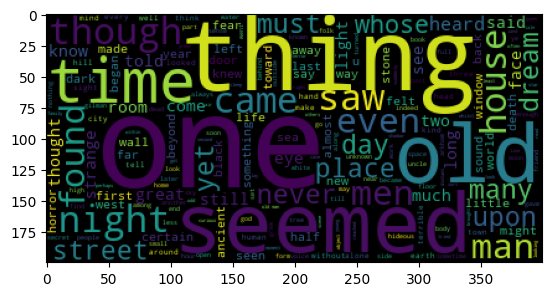

In [110]:
show_wordclouds(grouped_df, "HPL")

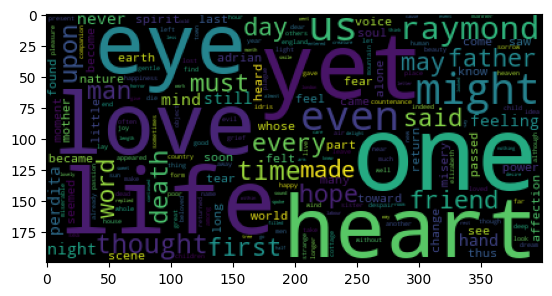

In [111]:
show_wordclouds(grouped_df, "MWS")

###  5. En utilisant la fonction wordCloud, montrer les 100 meilleurs mots positifs et négatifs utilisés par les auteurs.  

In [114]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...


True

In [115]:
from nltk.sentiment import SentimentIntensityAnalyzer
import numpy as np

class WordSentitmentAnalyser:

    def __init__(self):
        self.sia = SentimentIntensityAnalyzer()

    def classify_word(self, word):
        return self.sia.polarity_scores(word)["compound"]

    def analyse_words(self, words):
        sentiment_scores = np.array(list(map(self.classify_word, words)))
        return sentiment_scores

    def plot_topk_words(self,words,mask=None,word_cloud_config={},pos_config={},neg_config={},k=100):
        sentiment_scores = self.analyse_words(words)
        sentiment_scores_idx = sentiment_scores.argsort()
        top_k_positive_words = words[sentiment_scores_idx[-k:]]
        top_k_negative_words = words[sentiment_scores_idx[:k]]

        positive_word_cloud = WordCloud(**{**word_cloud_config,**pos_config})
        negative_word_cloud = WordCloud(**{**word_cloud_config,**neg_config})

        positive_word_cloud.generate_from_text(' '.join(top_k_positive_words))
        negative_word_cloud.generate_from_text(' '.join(top_k_negative_words))

        positive_word_cloud.recolor(colormap='Greens')
        negative_word_cloud.recolor(colormap='Reds')

        word_cloud = np.vstack([positive_word_cloud.to_array(),negative_word_cloud.to_array()])

        plt.imshow(word_cloud)
        



This class is designed to analyze the sentiment of individual words using **VADER Sentiment Analysis** (``SentimentIntensityAnalyzer``).

```python
def classify_word(self, word):
    return self.sia.polarity_scores(word)["compound"]

```
Computes the sentiment score (between -1 and +1) for a given word.
  - Positive words → Positive score (close to +1)
  - Negative words → Negative score (close to -1)
  - Neutral words → Score around 0


```python
def analyse_words(self, words):
    sentiment_scores = np.array(list(map(self.classify_word, words)))
    return sentiment_scores
```

Analyzes a list of words and returns their sentiment scores as a NumPy array.

**Function ``plot_topk_words``**: <br>
This function creates two WordClouds:
- One for the top 100 positive words
- One for the top 100 negative words

```python
word_cloud = np.vstack([positive_word_cloud.to_array(),negative_word_cloud.to_array()])
```

Stacks the two WordCloud images together.

```python
plt.imshow(word_cloud)
```

Displays the final visualization.

In [116]:
analyzer = WordSentitmentAnalyser()

In [119]:
mask = plt.imread('black-pear.jpg')
pos_mask = mask[:1500]
neg_mask = mask[1500:]

Extracts all words that appear in Edgar Allan Poe's text

In [120]:
eap_words = counts_df.columns[counts_df.loc["EAP"] != 0]

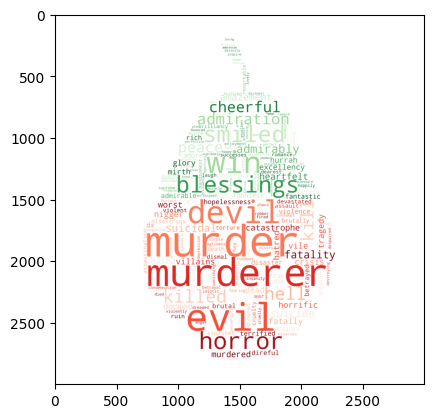

In [121]:
analyzer.plot_topk_words(
    eap_words,
    word_cloud_config={"background_color": "white"},
    pos_config={"mask": pos_mask},
    neg_config={"mask": neg_mask}
)

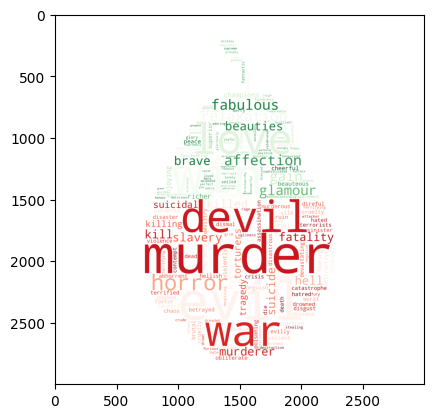

In [122]:
hpl_words = counts_df.columns[counts_df.loc["HPL"] != 0]
analyzer.plot_topk_words(hpl_words,
    word_cloud_config={"background_color":"white"},
    pos_config={"mask":pos_mask},
    neg_config={"mask":neg_mask}
)

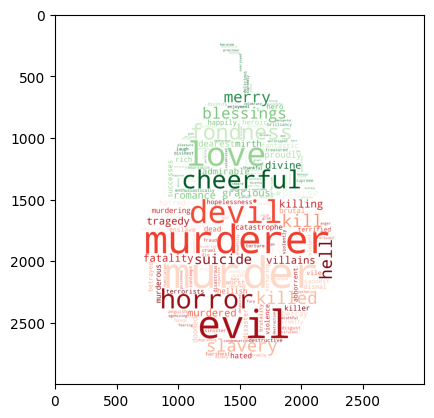

In [123]:
mws_words = counts_df.columns[counts_df.loc["MWS"] != 0]
analyzer.plot_topk_words(mws_words,
    word_cloud_config={"background_color":"white"},
    pos_config={"mask":pos_mask},
    neg_config={"mask":neg_mask}
)

### 6.  Identifier la polarité la plus fréquente pour chaque auteur (analyse de sentiment).

In [125]:
def get_sentiment(text):
    score = analyzer.classify_word(text) 
    if score > 0:
        return "Positive"
    elif score < 0:
        return "Negative"
    else:
        return "Neutral"


In [126]:
df["sentiment"] = df["text"].apply(get_sentiment)
sentiment_counts = df.groupby("author")["sentiment"].apply(lambda x: Counter(x).most_common(1)[0][0])
sentiment_counts

author
EAP    Positive
HPL    Negative
MWS    Positive
Name: sentiment, dtype: object

In [127]:
def unique_word_count(texts):
    words = ' '.join(texts).split()
    return len(set(words))

In [130]:
import seaborn as sns
def plot_text_length_distribution(df, column):
    df["text_length"] = df[column].apply(lambda x: len(x.split()))
    plt.figure(figsize=(10, 5))
    sns.histplot(df["text_length"], bins=30, kde=True)
    plt.title(f"Text Length Distribution ({column})")
    plt.xlabel("Number of Words")
    plt.ylabel("Frequency")
    plt.show()

In [131]:
original_words = unique_word_count(df["text"])
print(f"Original unique words: {original_words}")

Original unique words: 24911


In [132]:
df["no_stopwords"] = df["text"].apply(remove_stopwords)
stopword_removed_words = unique_word_count(df["no_stopwords"])

In [133]:
df["stemmed"] = df["text"].apply(stem)
stemmed_words = unique_word_count(df["stemmed"])

In [134]:
df["lemmatized"] = df["text"].apply(lemmatize)
lemmatized_words = unique_word_count(df["lemmatized"])

In [135]:
print(f"Original unique words: {original_words}")
print(f"After stopword removal: {stopword_removed_words}")
print(f"After stemming: {stemmed_words}")
print(f"After lemmatization: {lemmatized_words}")

Original unique words: 24911
After stopword removal: 24911
After stemming: 15004
After lemmatization: 22010


## Summary of the NLP Lab (TP) on Text Preprocessing and Analysis

### A. Text Cleaning and Preprocessing
1. **Removing Stopwords**
  - Used NLTK's stopword list to remove common words (e.g., "the", "is") that do not contribute much meaning.
  - Tokenized text and removed words present in the English stopword list.
2. **Language Detection and Translation**
  - Used a language detection function to determine the language of each sentence.
  - Translated all sentences into the most frequently occurring language in the dataset.
3. **Handling Homoglyphs and Special Characters**
  - Detected homoglyphs (characters that look similar but are different) and normalized them.
  - Removed special characters using regex-based substitution.
4. **Removing Repeated Words and Extra Spaces**
  - Used regex to replace duplicated words (e.g., "hello hello hello" → "hello").
  - Also removed unnecessary whitespace between words.

### B. Text Segmentation
1. **Space and Punctuation-Based Segmentation**
  - Tokenized sentences by splitting them on spaces and punctuation using word_tokenize.
2. **Rule-Based Segmentation**
  - Defined rules for handling contractions and informal words (e.g., "can't" → ["can", "not"], "gimme" → ["give", "me"]).
  - Implemented a custom tokenizer using spaCy to apply these rules.
3. **Subword Tokenization**
  - Used WordPiece Tokenization, a subword-based segmentation method.
  - Applied tokenization to split words into meaningful subunits, improving handling of unknown words.

### C. Named Entity Recognition (NER) and POS Tagging
1. **Named Entity Recognition (NER)**
  - Used spaCy’s "en_core_web_lg" model to extract named entities (e.g., locations, persons, dates).
  - Identified and printed named entities along with their labels.
2. **Part-of-Speech (POS) Tagging**
  - Applied POS tagging to label each word’s grammatical category (noun, verb, adjective, etc.).

### D. Lemmatization and Stemming
1. **Stemming (Using SnowballStemmer)**
  - Reduced words to their root form (e.g., "running" → "run", "generalization" → "general").
  - Applied stemming to the dataset and stored the results.
2. **Lemmatization (Using WordNetLemmatizer)**
  - Converted words to their dictionary form while preserving meaning (e.g., "better" → "good").
  - Compared stemming vs. lemmatization to assess effectiveness.

### E. Frequency Analysis and Sentiment Analysis
1. **Word Frequency Count (Per Author)**
  - Used CountVectorizer to count word occurrences in each author's text.
  - Extracted and analyzed the frequency of the word "Great" per author.
2. **Word Cloud Visualization (Most Used Words per Author)**
  - Generated WordClouds to visualize the most frequently used words for each author.
3. **Sentiment Analysis of Words**
  - Implemented a sentiment analyzer using NLTK’s SentimentIntensityAnalyzer.
  - Classified words as positive or negative and created separate word clouds for positive and negative words.
4. **Sentiment Analysis per Author**
  - Analyzed the most common sentiment (positive, neutral, or negative) for each author.
  - Counted occurrences of each sentiment category to determine which sentiment was most frequent per author.